# Kaggle Titanic survival -more TensorFlow.

* Add droput layer after inputs
* Separate out activation into separate layers
* Separate out layer definition and flow
* Use Leaky ReLu activation

In [ ]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import numpy as np
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Download data if not previously downloaded

In [3]:
download_required = False

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to calculate accuracy measurements

In [4]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Define function to scale data

In neural networks it is common to to scale input data 0-1 rather than use standardisation (subtracting mean and dividing by standard deviation) of each feature).

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc
    

## Load data

In [6]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

# Set up neural net



In [7]:
def make_net(number_features, learning_rate=0.003):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Define layers
    input_layer = layers.Input(shape=number_features,  name='main_input')
    dropout_1 = layers.Dropout(0.25)
    dense_1 = layers.Dense(240)
    activation_1 = layers.LeakyReLU(alpha=0.1)
    norm_1 = layers.BatchNormalization()
    dropout_2 = layers.Dropout(0.25)
    dense_2 = layers.Dense(50)
    activation_2 = layers.LeakyReLU(alpha=0.1)
    dense_3 = layers.Dense(1)
    output_layer = layers.Activation('sigmoid', name='sigmoid_output')
    
    # Define flow
    inputs = input_layer
    x = dropout_1(inputs)
    x = dense_1(x)
    x = activation_1(x)
    x = norm_1(x)
    x = dropout_2(x)
    x = dense_2(x)
    x = activation_2(x)
    x = dense_3(x)
    outputs = output_layer(x)
    
    # Construct net
    net = Model(inputs, outputs)
      
    # Compiling model
    net.compile(loss='binary_crossentropy',
    optimizer=Adam(lr=learning_rate),
    metrics=['accuracy'])
    return net


## Show summary of the model structure

Here we will create a model with 10 input features and show the structure of the model as  atable and as a graph.

In [8]:
model = make_net(10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 240)               2640      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 240)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 240)               960       
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12050 

In [9]:
# If necessary pip or conda install pydot and graphviz
keras.utils.plot_model(model, "titanic_tf_model.png", show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


## Set dictionary of weights according to class distribution

Here we will create a dictionary of class weights, in inverse proportion to how frequently a class occurs (to less frequent classes will be given more weight in model).

In [10]:
# Get proportion of each class
prop_class_1 = y.mean()
prop_class_0 = 1 - prop_class_1

# Set weights in inverse propotion to occurance
weight_class_0 = 1 / prop_class_0
weight_class_1 = 1 / prop_class_1

# Create dictionary of class weight
class_weights = {0: weight_class_0, 1: weight_class_1}

## Run the model with k-fold validation

In [11]:
# Set up lists to hold results
training_acc_results = []
test_acc_results = []

# Set up splits
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
k_counter = 0

for train_index, test_index in skf.split(X_np, y_np):
    k_counter +=1
    print('K_fold {}'.format(k_counter))
    
    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]
    
    # Scale X data
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]
    model = make_net(number_features)
    
    # Define save checkpoint callback (only save if new best validation results)
    checkpoint_cb = keras.callbacks.ModelCheckpoint('model_checkpoint.h5',
                                                save_best_only=True)

    # Define early stopping callback
    # Stop when no validation improvement for 25 epochs)
    # Restore weights to best validation accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=25,
                                                      restore_best_weights=True)

    ### Train model
    model.fit(X_train_sc,
            y_train,
            class_weight = class_weights,
            epochs=250,
            batch_size=32,
            validation_data=(X_test_sc, y_test),
            verbose=0,
            callbacks=[checkpoint_cb, early_stopping_cb])
            
    ### Test model (print results for each k-fold iteration)
    probability = model.predict(X_train_sc)
    y_pred_train = probability >= 0.5
    y_pred_train = y_pred_train.flatten()
    accuracy_train = np.mean(y_pred_train == y_train)
    training_acc_results.append(accuracy_train)

    probability = model.predict(X_test_sc)
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten()
    accuracy_test = np.mean(y_pred_test == y_test)
    test_acc_results.append(accuracy_test)

K_fold 1
K_fold 2
K_fold 3
K_fold 4
K_fold 5


## Show training and test results

In [12]:
# Show individual accuracies on training data
training_acc_results

[0.8103932584269663,
 0.814866760168303,
 0.8120617110799438,
 0.820476858345021,
 0.7980364656381487]

In [13]:
# Show individual accuracies on test data
test_acc_results

[0.7653631284916201,
 0.8033707865168539,
 0.7921348314606742,
 0.7696629213483146,
 0.8314606741573034]

In [14]:
# Get mean results
mean_training = np.mean(training_acc_results)
mean_test = np.mean(test_acc_results)

# Display each to three decimal places
print ('{0:.3f}, {1:.3}'.format(mean_training,mean_test))

0.811, 0.792


## Plot results: Box Plot

Box plots show median (orange line), the second and third quartiles (the box), the range (excluding outliers), and any outliers as 'whisker' points. Outliers, by convention, are conisiered to be any points outside of the quartiles +/- 1.5 times the interquartile range. The limit for outliers may be changed using the optional `whis` argument in the boxplot.

Medians tend to be an easy reliable guide to the centre of a distribution (i.e. look at the medians to see whether a fit is improving or not, but also look at the box plot to see how much variability there is).

Test sets tend to be more variable in their accuracy measures. Can you think why?

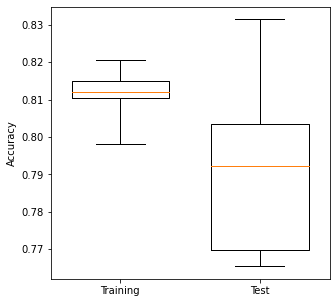

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up X data 
x_for_box = [training_acc_results, test_acc_results]

# Set up X labels
labels = ['Training', 'Test'] 

# Set up figure
fig = plt.figure(figsize=(5,5))

# Add subplot (can be used to define multiple plots in same figure)
ax1 = fig.add_subplot(111)

# Define Box Plot (`widths` is optional)
ax1.boxplot(x_for_box, 
            widths=0.7,
            whis=100)

# Set X and Y labels
ax1.set_xticklabels(labels)
ax1.set_ylabel('Accuracy')

# Show plot
plt.show()